In [161]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

In [162]:
# additional libraries
import pandas as pd
import numpy as np
import spacy
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep

# sklearn utils
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

In [249]:
####
# Network
####
class Model(nn.Module):
    def __init__(self, seq_len, input_size, h_in, device):
        super(Model, self).__init__()
        
        self.num_layers = 1
        self.seq_len    = seq_len
        self.h_in       = h_in
        self.device     = device
        self.input_size = input_size
        
        self.lstm = nn.LSTM(input_size = self.input_size, 
                            hidden_size = self.h_in, 
                            num_layers = self.num_layers,
                            batch_first=True
                           )
        
        self.fc1 = nn.Linear(h_in, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(16, 1)
        
    def forward(self, x):
        output, (hn, cn) = self.lstm(x.float())
#         out = cn.view(-1, self.h_in)
        out = torch.mean(output, axis=1)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.bn3(out)
#         out = self.relu(out)
        out = self.fc(out).view(len(x))
        
        return out

In [194]:
torch.mean(torch.rand(32, 600, 50), axis=1).shape

torch.Size([32, 50])

In [196]:
#####
# Model Trainer
#####

class ModelBuilder:
    def __init__(self, nlp, seq_len):
        self.seq_len = seq_len
        self.nlp = nlp
        self.embed_dim = 300
        
    def get_features(self, texts):
        with self.nlp.disable_pipes():
            nlp_texts = [self.nlp(text) for text in texts]
        feats = np.zeros((len(nlp_texts), self.seq_len, self.embed_dim))

        for i in range(len(nlp_texts)):
            text = nlp_texts[i]
            feats[i][0:min(len(text), self.seq_len)] = [word.vector for word in text[0:min(len(text), self.seq_len)]]
            
        return feats
    
    def get_data_loaders(self, feats, labels, test_size=0.1, train_args={}, test_args={}):
        X_train, X_test, y_train, y_test = train_test_split(feats, labels, test_size=test_size)
        
        dataloader_train = DataLoader(list(zip(X_train, y_train)), **train_args)
        dataloader_test  = DataLoader(list(zip(X_test, y_test)), **test_args)
        
        return dataloader_train, dataloader_test
        
        
    def train(self, model, train, test, optimizer, criterion, num_epochs, device):
        train_losses = []
        test_losses  = []
        
        model = model.to(device)
        
        for epoch in range(num_epochs):
            sleep(1)
            train_loss = 0
            test_loss = 0
            n = 0
            n_test = 0
            
            tq = tqdm(train)
            it_str = 'Epoch {0: d}, Train MSE: {1: 5.6f}'
            tq.set_description(it_str.format(epoch + 1, float(0)))
            
            
            model.train()
            for inputs, targets in tq:
                inputs, targets = inputs.to(device).float(), targets.to(device).float()
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * len(inputs)
                n += len(inputs)
                tq.set_description(it_str.format(epoch + 1, train_loss / n))
                
            model.eval()
            
            with torch.no_grad():
                for inputs, targets in test:
                    inputs, targets = inputs.to(device).float(), targets.to(device).float()
                    outputs = model(inputs)
                    
                    loss = criterion(outputs, targets)
                    
                    test_loss += loss.item() * len(inputs)
                    n_test += len(inputs)
            
            print('Test MSE: {0: 5.6f}, Test RMSE: {1: 5.6f}'.format(test_loss / n_test, np.sqrt(test_loss / n_test)))
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        
        return model, {'train_losses': train_losses, 'test_losses': test_losses}
                    
                
        

In [200]:
wd = './'
train_path = wd + 'train.csv'
random_state = 1
seq_len = 600
input_size = 300
h_in = 300

In [89]:
np.random.seed(random_state)

In [90]:
data = pd.read_csv(train_path)

In [9]:
data['target'].describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

In [10]:
data['standard_error']

0       0.464009
1       0.480805
2       0.476676
3       0.450007
4       0.510845
          ...   
2829    0.646900
2830    0.535648
2831    0.483866
2832    0.514128
2833    0.512379
Name: standard_error, Length: 2834, dtype: float64

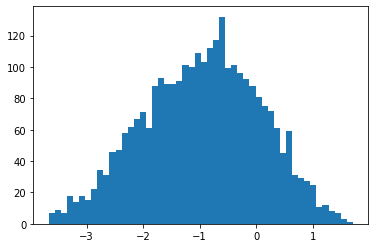

In [11]:
hist1 = plt.hist(data['target'], bins=50)
plt.show()

In [12]:
nlp = spacy.load("en_core_web_lg")
modelbuild = ModelBuilder(nlp, seq_len)

In [ ]:
feat = modelbuild.get_features(data['excerpt'])

In [242]:
train, test = modelbuild.get_data_loaders(feat, data['target'], 0.1, 
                                          train_args={'batch_size':32, 'shuffle':True},
                                          test_args={'batch_size': 32})

In [250]:
criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(seq_len,  input_size, h_in, device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

In [251]:
modelbuild.train(model, train, test, optimizer, criterion, 100, device)

Epoch  1, Train MSE:  0.790446: 100%|██████████| 80/80 [00:04<00:00, 19.46it/s]


Test MSE:  0.652038, Test RMSE:  0.807489


Epoch  2, Train MSE:  0.458457: 100%|██████████| 80/80 [00:04<00:00, 19.71it/s]


Test MSE:  0.492226, Test RMSE:  0.701588


Epoch  3, Train MSE:  0.415617: 100%|██████████| 80/80 [00:04<00:00, 19.70it/s]


Test MSE:  0.537757, Test RMSE:  0.733319


Epoch  4, Train MSE:  0.402427: 100%|██████████| 80/80 [00:04<00:00, 19.41it/s]


Test MSE:  0.462787, Test RMSE:  0.680285


Epoch  5, Train MSE:  0.355033: 100%|██████████| 80/80 [00:04<00:00, 19.72it/s]


Test MSE:  0.498087, Test RMSE:  0.705753


Epoch  6, Train MSE:  0.345988: 100%|██████████| 80/80 [00:04<00:00, 19.44it/s]


Test MSE:  0.495681, Test RMSE:  0.704046


Epoch  7, Train MSE:  0.322588: 100%|██████████| 80/80 [00:04<00:00, 19.67it/s]


Test MSE:  0.481965, Test RMSE:  0.694237


Epoch  8, Train MSE:  0.298836: 100%|██████████| 80/80 [00:04<00:00, 19.34it/s]


Test MSE:  0.922051, Test RMSE:  0.960235


Epoch  9, Train MSE:  0.286375: 100%|██████████| 80/80 [00:04<00:00, 19.54it/s]


Test MSE:  0.699017, Test RMSE:  0.836073


Epoch  10, Train MSE:  0.277940: 100%|██████████| 80/80 [00:04<00:00, 18.91it/s]


Test MSE:  0.507644, Test RMSE:  0.712491


Epoch  11, Train MSE:  0.274159: 100%|██████████| 80/80 [00:03<00:00, 20.08it/s]


Test MSE:  0.754558, Test RMSE:  0.868653


Epoch  12, Train MSE:  0.251243: 100%|██████████| 80/80 [00:04<00:00, 19.94it/s]


Test MSE:  0.525931, Test RMSE:  0.725211


Epoch  13, Train MSE:  0.234162: 100%|██████████| 80/80 [00:04<00:00, 19.21it/s]


Test MSE:  0.501150, Test RMSE:  0.707920


Epoch  14, Train MSE:  0.224163: 100%|██████████| 80/80 [00:04<00:00, 19.44it/s]


Test MSE:  0.569177, Test RMSE:  0.754438


Epoch  15, Train MSE:  0.228003: 100%|██████████| 80/80 [00:04<00:00, 20.00it/s]


Test MSE:  0.537608, Test RMSE:  0.733218


Epoch  16, Train MSE:  0.202902: 100%|██████████| 80/80 [00:04<00:00, 19.90it/s]


Test MSE:  0.731313, Test RMSE:  0.855168


Epoch  17, Train MSE:  0.188884: 100%|██████████| 80/80 [00:04<00:00, 19.36it/s]


Test MSE:  0.566350, Test RMSE:  0.752562


Epoch  18, Train MSE:  0.194167: 100%|██████████| 80/80 [00:04<00:00, 18.80it/s]


Test MSE:  0.587841, Test RMSE:  0.766708


Epoch  19, Train MSE:  0.183423: 100%|██████████| 80/80 [00:04<00:00, 19.30it/s]


Test MSE:  0.635802, Test RMSE:  0.797372


Epoch  20, Train MSE:  0.173473: 100%|██████████| 80/80 [00:04<00:00, 19.94it/s]


Test MSE:  0.561119, Test RMSE:  0.749079


Epoch  21, Train MSE:  0.168316: 100%|██████████| 80/80 [00:03<00:00, 20.10it/s]


Test MSE:  0.641872, Test RMSE:  0.801169


Epoch  22, Train MSE:  0.165063: 100%|██████████| 80/80 [00:03<00:00, 20.05it/s]


Test MSE:  0.589261, Test RMSE:  0.767633


Epoch  23, Train MSE:  0.154350: 100%|██████████| 80/80 [00:03<00:00, 20.03it/s]


Test MSE:  0.592320, Test RMSE:  0.769623


Epoch  24, Train MSE:  0.152391: 100%|██████████| 80/80 [00:03<00:00, 20.07it/s]


Test MSE:  0.647185, Test RMSE:  0.804478


Epoch  25, Train MSE:  0.161095: 100%|██████████| 80/80 [00:03<00:00, 20.07it/s]


Test MSE:  0.592047, Test RMSE:  0.769446


Epoch  26, Train MSE:  0.141887: 100%|██████████| 80/80 [00:03<00:00, 20.08it/s]


Test MSE:  0.632523, Test RMSE:  0.795313


Epoch  27, Train MSE:  0.137076: 100%|██████████| 80/80 [00:03<00:00, 20.10it/s]


Test MSE:  0.713784, Test RMSE:  0.844858


Epoch  28, Train MSE:  0.130919: 100%|██████████| 80/80 [00:03<00:00, 20.10it/s]


Test MSE:  0.975104, Test RMSE:  0.987473


Epoch  29, Train MSE:  0.128637: 100%|██████████| 80/80 [00:03<00:00, 20.08it/s]


Test MSE:  0.614895, Test RMSE:  0.784152


Epoch  30, Train MSE:  0.134289: 100%|██████████| 80/80 [00:03<00:00, 20.12it/s]


Test MSE:  0.540851, Test RMSE:  0.735426


Epoch  31, Train MSE:  0.122751: 100%|██████████| 80/80 [00:03<00:00, 20.09it/s]


Test MSE:  0.569755, Test RMSE:  0.754821


Epoch  32, Train MSE:  0.127084: 100%|██████████| 80/80 [00:03<00:00, 20.10it/s]


Test MSE:  0.611110, Test RMSE:  0.781735


Epoch  33, Train MSE:  0.132257: 100%|██████████| 80/80 [00:04<00:00, 19.83it/s]


Test MSE:  0.590793, Test RMSE:  0.768630


Epoch  34, Train MSE:  0.109774: 100%|██████████| 80/80 [00:03<00:00, 20.12it/s]


Test MSE:  0.634637, Test RMSE:  0.796641


Epoch  35, Train MSE:  0.110292: 100%|██████████| 80/80 [00:03<00:00, 20.19it/s]


Test MSE:  0.564765, Test RMSE:  0.751509


Epoch  36, Train MSE:  0.099325: 100%|██████████| 80/80 [00:03<00:00, 20.05it/s]


Test MSE:  0.547845, Test RMSE:  0.740166


Epoch  37, Train MSE:  0.109593: 100%|██████████| 80/80 [00:03<00:00, 20.14it/s]


Test MSE:  0.595816, Test RMSE:  0.771891


Epoch  38, Train MSE:  0.123940: 100%|██████████| 80/80 [00:04<00:00, 19.98it/s]


Test MSE:  0.624424, Test RMSE:  0.790205


Epoch  39, Train MSE:  0.111169: 100%|██████████| 80/80 [00:04<00:00, 19.97it/s]


Test MSE:  0.990839, Test RMSE:  0.995409


Epoch  40, Train MSE:  0.109457: 100%|██████████| 80/80 [00:04<00:00, 19.97it/s]


Test MSE:  0.693331, Test RMSE:  0.832665


Epoch  41, Train MSE:  0.100641: 100%|██████████| 80/80 [00:04<00:00, 19.68it/s]


Test MSE:  0.584657, Test RMSE:  0.764629


Epoch  42, Train MSE:  0.109243: 100%|██████████| 80/80 [00:04<00:00, 18.94it/s]


Test MSE:  0.745601, Test RMSE:  0.863482


Epoch  43, Train MSE:  0.097390: 100%|██████████| 80/80 [00:03<00:00, 20.07it/s]


Test MSE:  0.564060, Test RMSE:  0.751040


Epoch  44, Train MSE:  0.102370: 100%|██████████| 80/80 [00:03<00:00, 20.15it/s]


Test MSE:  0.556750, Test RMSE:  0.746157


Epoch  45, Train MSE:  0.093544: 100%|██████████| 80/80 [00:03<00:00, 20.06it/s]


Test MSE:  0.602962, Test RMSE:  0.776506


Epoch  46, Train MSE:  0.096822: 100%|██████████| 80/80 [00:03<00:00, 20.10it/s]


Test MSE:  1.096511, Test RMSE:  1.047144


Epoch  47, Train MSE:  0.086870: 100%|██████████| 80/80 [00:03<00:00, 20.19it/s]


Test MSE:  0.635879, Test RMSE:  0.797420


Epoch  48, Train MSE:  0.099489: 100%|██████████| 80/80 [00:03<00:00, 20.12it/s]


Test MSE:  0.560211, Test RMSE:  0.748472


Epoch  49, Train MSE:  0.101065: 100%|██████████| 80/80 [00:03<00:00, 20.15it/s]


Test MSE:  0.532320, Test RMSE:  0.729602


Epoch  50, Train MSE:  0.088814: 100%|██████████| 80/80 [00:03<00:00, 20.07it/s]


Test MSE:  0.561309, Test RMSE:  0.749206


Epoch  51, Train MSE:  0.109318: 100%|██████████| 80/80 [00:03<00:00, 20.16it/s]


Test MSE:  0.550990, Test RMSE:  0.742287


Epoch  52, Train MSE:  0.100128: 100%|██████████| 80/80 [00:03<00:00, 20.12it/s]


Test MSE:  0.552799, Test RMSE:  0.743504


Epoch  53, Train MSE:  0.077419: 100%|██████████| 80/80 [00:03<00:00, 20.12it/s]


Test MSE:  0.589030, Test RMSE:  0.767483


Epoch  54, Train MSE:  0.091816: 100%|██████████| 80/80 [00:03<00:00, 20.17it/s]


Test MSE:  0.563944, Test RMSE:  0.750962


Epoch  55, Train MSE:  0.093919: 100%|██████████| 80/80 [00:03<00:00, 20.11it/s]


Test MSE:  0.537807, Test RMSE:  0.733353


Epoch  56, Train MSE:  0.096898: 100%|██████████| 80/80 [00:03<00:00, 20.02it/s]


Test MSE:  0.538269, Test RMSE:  0.733668


Epoch  57, Train MSE:  0.087164: 100%|██████████| 80/80 [00:04<00:00, 19.39it/s]


Test MSE:  0.524961, Test RMSE:  0.724542


Epoch  58, Train MSE:  0.086211: 100%|██████████| 80/80 [00:04<00:00, 19.15it/s]


Test MSE:  0.641322, Test RMSE:  0.800826


Epoch  59, Train MSE:  0.091651: 100%|██████████| 80/80 [00:04<00:00, 18.58it/s]


Test MSE:  0.556390, Test RMSE:  0.745916


Epoch  60, Train MSE:  0.083510: 100%|██████████| 80/80 [00:04<00:00, 18.64it/s]


Test MSE:  0.547204, Test RMSE:  0.739732


Epoch  61, Train MSE:  0.080012: 100%|██████████| 80/80 [00:04<00:00, 19.87it/s]


Test MSE:  0.571898, Test RMSE:  0.756239


Epoch  62, Train MSE:  0.083098: 100%|██████████| 80/80 [00:04<00:00, 19.95it/s]


Test MSE:  0.537150, Test RMSE:  0.732906


Epoch  63, Train MSE:  0.086760: 100%|██████████| 80/80 [00:03<00:00, 20.02it/s]


Test MSE:  0.556658, Test RMSE:  0.746095


Epoch  64, Train MSE:  0.091783: 100%|██████████| 80/80 [00:04<00:00, 19.70it/s]


Test MSE:  0.580812, Test RMSE:  0.762110


Epoch  65, Train MSE:  0.080715: 100%|██████████| 80/80 [00:04<00:00, 19.34it/s]


Test MSE:  0.552326, Test RMSE:  0.743186


Epoch  66, Train MSE:  0.086101: 100%|██████████| 80/80 [00:04<00:00, 19.61it/s]


Test MSE:  0.661360, Test RMSE:  0.813240


Epoch  67, Train MSE:  0.092474: 100%|██████████| 80/80 [00:04<00:00, 19.87it/s]


Test MSE:  0.586151, Test RMSE:  0.765605


Epoch  68, Train MSE:  0.084420: 100%|██████████| 80/80 [00:04<00:00, 19.26it/s]


Test MSE:  0.728101, Test RMSE:  0.853288


Epoch  69, Train MSE:  0.083880: 100%|██████████| 80/80 [00:04<00:00, 18.91it/s]


Test MSE:  0.622298, Test RMSE:  0.788859


Epoch  70, Train MSE:  0.079649: 100%|██████████| 80/80 [00:04<00:00, 19.45it/s]


Test MSE:  0.546301, Test RMSE:  0.739122


Epoch  71, Train MSE:  0.072385: 100%|██████████| 80/80 [00:04<00:00, 19.67it/s]


Test MSE:  0.526273, Test RMSE:  0.725446


Epoch  72, Train MSE:  0.074477: 100%|██████████| 80/80 [00:04<00:00, 19.43it/s]


Test MSE:  0.635196, Test RMSE:  0.796992


Epoch  73, Train MSE:  0.074665: 100%|██████████| 80/80 [00:04<00:00, 19.77it/s]


Test MSE:  0.531296, Test RMSE:  0.728901


Epoch  74, Train MSE:  0.085252: 100%|██████████| 80/80 [00:04<00:00, 19.80it/s]


Test MSE:  0.511543, Test RMSE:  0.715222


Epoch  75, Train MSE:  0.076822: 100%|██████████| 80/80 [00:04<00:00, 19.45it/s]


Test MSE:  0.577807, Test RMSE:  0.760136


Epoch  76, Train MSE:  0.067206:  85%|████████▌ | 68/80 [00:03<00:00, 19.41it/s]


KeyboardInterrupt: 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_vecs, data_lbls, test_size=0.1)

In [17]:
np.sqrt(mean_squared_error(np.full((data.shape[0],),data['target'].mean()), data['target']))

1.033396832247627

In [100]:
params = {
    'base_score': 0.5,
    'n_estimators': 200,
    'max_depth': 2,
    'learning_rate': 0.1,
    'verbosity': 1,2
    'random_state': random_state
}
model = xgb.XGBRegressor(objective="reg:squarederror", **params)

In [101]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [102]:
y_pred = model.predict(X_test)

In [104]:
np.sqrt(mean_squared_error(y_pred, y_test))

0.6603736247497498